Import the required Libraries and Load the Datasets

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

Convert TransactionDate and SignUp into Datetime Format

In [4]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

Merge transactions with product information

In [5]:
transactions_products = transactions.merge(products, on='ProductID')

Aggregate transaction data per customer

In [6]:
customer_transactions = transactions_products.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    TransactionCount=('TransactionID', 'count'),
    **{f"Category_{cat}": ('TotalValue', lambda x: x.sum()) for cat in products['Category'].unique()}
).reset_index()

Merge with customer profile data

In [7]:
data = pd.merge(customers, customer_transactions, on='CustomerID', how='inner')

Encode categorical data (Region)

In [8]:
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

Select features for clustering

In [9]:
features = [
    'TotalSpent', 'TotalQuantity', 'TransactionCount',
    *[col for col in data.columns if col.startswith('Category_')]
]

Standardize the features

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

**Apply K-Means Clustering**

In [12]:
optimal_clusters = 0
lowest_db_index = float('inf')
cluster_results = {}

Test cluster sizes from 2 to 10

In [26]:
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    db_index = davies_bouldin_score(data_scaled, cluster_labels)
    print(f"Number of Clusters: {n_clusters}, Davies-Bouldin Index: {db_index}")
    cluster_results[n_clusters] = (kmeans, cluster_labels, db_index)
    if db_index < lowest_db_index:
        lowest_db_index = db_index
        optimal_clusters = n_clusters

Number of Clusters: 2, Davies-Bouldin Index: 0.6537721410831263
Number of Clusters: 3, Davies-Bouldin Index: 0.7441213151525697
Number of Clusters: 4, Davies-Bouldin Index: 0.780562691836624
Number of Clusters: 5, Davies-Bouldin Index: 0.8229576896506423
Number of Clusters: 6, Davies-Bouldin Index: 0.8783932029801824
Number of Clusters: 7, Davies-Bouldin Index: 0.9119246034371675
Number of Clusters: 8, Davies-Bouldin Index: 1.046974579142737
Number of Clusters: 9, Davies-Bouldin Index: 1.0051604724578025
Number of Clusters: 10, Davies-Bouldin Index: 0.9487055045899344


Best clustering result

In [29]:
best_kmeans, best_labels, best_db_index = cluster_results[optimal_clusters]
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {best_db_index}")

Optimal number of clusters: 2
Davies-Bouldin Index: 0.6537721410831263


Add cluster labels to data

In [30]:
data['Cluster'] = best_labels

Plot and Visualise the optimal Clusters

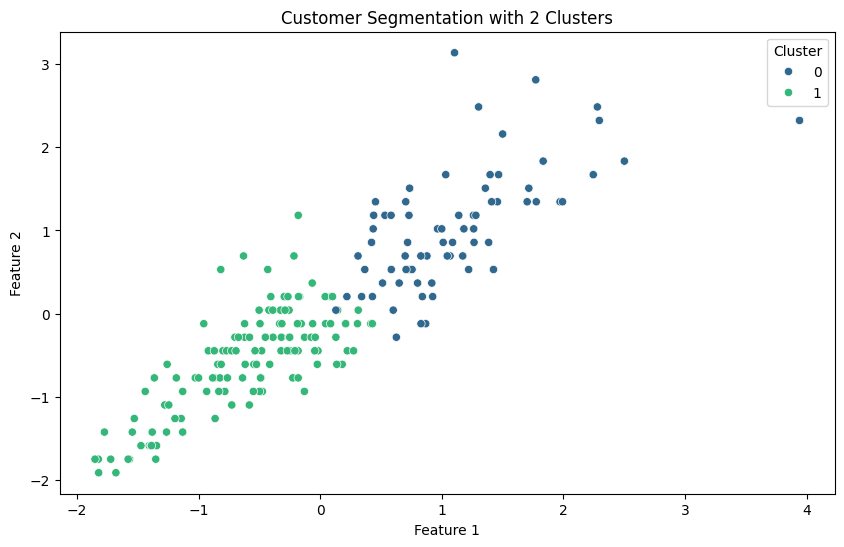

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_scaled[:, 0], y=data_scaled[:, 1], hue=best_labels, palette='viridis')
plt.title(f'Customer Segmentation with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster')
plt.show()

Final Output

In [32]:
{
    "Optimal Clusters": optimal_clusters,
    "DB Index": best_db_index,
}

{'Optimal Clusters': 2, 'DB Index': 0.6537721410831263}